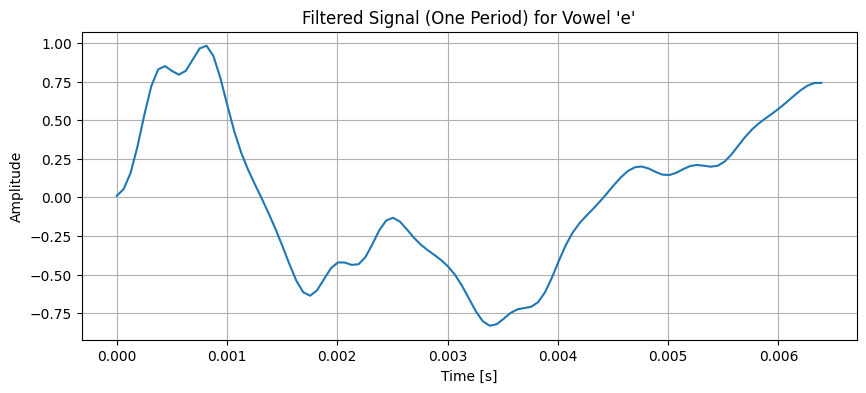

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from IPython.display import Audio

# ------------------------------------------------------------------
# 1. Excitation Generation Using Fourier Domain Design
# ------------------------------------------------------------------

def excitation_fourier(Fs, f0, num_periods, max_harmonic, wave_morph):
    """
    Create an excitation signal whose period is constructed via a frequency-domain
    design. Instead of using a delta (impulse) each period, we design a pulse with
    Fourier series coefficients that depend on wave_morph, where:
    
       wave_morph = 0: pure sine (only the fundamental is nonzero)
       wave_morph = 1: triangle (only odd harmonics, ~1/n^2)
       wave_morph = 2: square (only odd harmonics, ~1/n)
       wave_morph = 3: sawtooth (all harmonics, ~1/n)
    
    Values in between linearly interpolate between the two nearest wave types.
    
    Returns a time-domain excitation signal repeated for num_periods.
    """
    N_period = int(Fs / f0)  # One period in samples
    N = N_period             # We design one period first
    
    # Create an array for the frequency-domain representation (complex spectrum)
    X = np.zeros(N, dtype=complex)
    
    # Fourier series coefficient helper functions.
    def coeff_sine(n):
        return 1.0 if n == 1 else 0.0

    def coeff_triangle(n):
        if n % 2 == 1:
            return 8 / np.pi**2 * ((-1)**((n-1)//2)) / (n**2)
        else:
            return 0.0

    def coeff_square(n):
        if n % 2 == 1:
            return 4 / (np.pi * n)
        else:
            return 0.0

    def coeff_sawtooth(n):
        return 2 / (np.pi * n) * ((-1)**(n+1))
    
    # For each harmonic from 1 to max_harmonic, compute an interpolated coefficient.
    for n in range(1, max_harmonic + 1):
        lower = int(np.floor(wave_morph))
        upper = int(np.ceil(wave_morph))
        frac = wave_morph - lower

        # Coefficient for lower waveform type.
        if lower == 0:
            coef_lower = coeff_sine(n)
        elif lower == 1:
            coef_lower = coeff_triangle(n)
        elif lower == 2:
            coef_lower = coeff_square(n)
        elif lower == 3:
            coef_lower = coeff_sawtooth(n)
        else:
            coef_lower = 0.0

        # Coefficient for upper waveform type.
        if upper == 0:
            coef_upper = coeff_sine(n)
        elif upper == 1:
            coef_upper = coeff_triangle(n)
        elif upper == 2:
            coef_upper = coeff_square(n)
        elif upper == 3:
            coef_upper = coeff_sawtooth(n)
        else:
            coef_upper = 0.0

        # Linear interpolation between the two types.
        coef = (1 - frac) * coef_lower + frac * coef_upper

        # For a real signal, place half the coefficient at the positive frequencies,
        # and its conjugate at the corresponding negative frequencies.
        X[n] = coef / 2.0
        X[-n] = np.conjugate(coef / 2.0)

    X[0] = 0.0  # Zero DC component.
    one_period = np.fft.ifft(X)
    one_period = np.real(one_period)
    
    # Tile one period to create the full excitation signal.
    excitation = np.tile(one_period, num_periods)
    return excitation

# ------------------------------------------------------------------
# 2. Define Vowel Formant Parameters (First 3 Formants)
# ------------------------------------------------------------------
# The following dictionary contains approximate formant frequencies (in Hz)
# and bandwidths (in Hz) for common vowels.
# Format: vowel: [(F1, B1), (F2, B2), (F3, B3)]
vowel_formants = {
    "a": [(730, 80), (1090, 90), (2440, 120)],  # /a/ as in "father"
    "i": [(270, 60), (2290, 100), (3010, 120)],  # /i/ as in "beet"
    "u": [(300, 60), (870, 100), (2240, 120)],   # /u/ as in "boot"
    "e": [(530, 80), (1840, 90), (2480, 120)],   # /e/ as in "bait"
    "o": [(570, 80), (840, 100), (2410, 120)]     # /o/ as in "boat"
}

# Choose a vowel to synthesize.
vowel = "e"  # Change this to "i", "u", "e", or "o" as desired.
formants = vowel_formants[vowel]

# ------------------------------------------------------------------
# 3. Create a Combined Three-Formant Filter
# ------------------------------------------------------------------
def create_combined_filter(Fs, formant_list):
    """
    Given the sampling frequency Fs and a list of formant parameters,
    create a combined filter by convolving the denominator coefficients of
    second-order filters for each formant.
    
    formant_list: List of tuples [(F1, B1), (F2, B2), (F3, B3)]
    Returns: Combined denominator coefficients.
    """
    a_combined = np.array([1.0])
    for (F, B) in formant_list:
        f = F / Fs
        b = B / Fs
        a1 = 2 * np.exp(-np.pi * b) * np.cos(2 * np.pi * f)
        a2 = np.exp(-2 * np.pi * b)
        a_coeff = np.array([1.0, -a1, a2])
        a_combined = np.convolve(a_combined, a_coeff)
    return a_combined

# Sampling and excitation parameters.
Fs = 16000         # Sampling frequency in Hz.
f0 = 155           # Fundamental frequency (glottal rate) in Hz.
num_periods = 500  # Number of periods (longer output).
max_harmonic = 25  # Maximum number of harmonics for excitation.
wave_morph = 0   # Excitation morph parameter (0: sine, 1: triangle, 2: square, 3: sawtooth).

# Generate the excitation signal.
excitation = excitation_fourier(Fs, f0, num_periods, max_harmonic, wave_morph)

# Create the combined three-formant filter using the chosen vowel's formants.
a_combined = create_combined_filter(Fs, formants)
b_coeff = [1.0]  # Numerator is simply 1.

# ------------------------------------------------------------------
# 4. Filter the Excitation Signal and Listen
# ------------------------------------------------------------------
filtered_signal = lfilter(b_coeff, a_combined, excitation)

# Plot a short segment of the filtered signal.
N_period = int(Fs / f0)
t_period = np.linspace(0, 1/f0, N_period, endpoint=False)
plt.figure(figsize=(10, 4))
plt.plot(t_period, filtered_signal[:N_period])
plt.title(f"Filtered Signal (One Period) for Vowel '{vowel}'")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Play the resulting vowel-like sound.
Audio(filtered_signal, rate=Fs)
